# Предсказание погоды с использованием временных рядов.
Задача: строить прогнозы погоды на основе исторических метеорологических данных.

Загрузка датасета

In [3]:
# Импорт библиотек
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Выгрузка данных из таблицы с тренировочными данными
train_data: np.ndarray = pd.read_csv("CSV/DailyDelhiClimateTrain.csv").values

# Выгрузка данных из таблицы с тестовыми данными
test_data: np.ndarray = pd.read_csv("CSV/DailyDelhiClimateTest.csv").values

train_data

array([['2013-01-01', 10.0, 84.5, 0.0, 1015.6666666666666],
       ['2013-01-02', 7.4, 92.0, 2.98, 1017.8],
       ['2013-01-03', 7.166666666666667, 87.0, 4.633333333333334,
        1018.6666666666666],
       ...,
       ['2016-12-30', 14.095238095238097, 89.66666666666667,
        6.266666666666667, 1017.904761904762],
       ['2016-12-31', 15.052631578947368, 87.0, 7.325, 1016.1],
       ['2017-01-01', 10.0, 100.0, 0.0, 1016.0]],
      shape=(1462, 5), dtype=object)

## Нормализация данных

Естественно, ни одна модель не сможет понять, что значит строковое представление даты "2017-01-01", так что давайте приведем значения первого столбца к целым числам (кол-во дней с начала отсчета)

Функция перевода даты в кол-во дней от 2013-01-01 (самая первая дата в таблице):

In [4]:
def days_since_zero_date(date_str: str) -> int:
	# Преобразование строки в объект datetime
	date_format: str = "%Y-%m-%d"
	date_obj = datetime.strptime(date_str, date_format)
	
	# Нулевая дата
	zero_date = datetime.strptime("2013-01-01", date_format)
	
	# Вычисление разницы в днях
	delta = date_obj - zero_date
	days = delta.days
	 
	return days

Теперь переведем все даты в загруженных таблицах в дни и выведем результат:

In [5]:
# Применяем ранее определенную функцию ко всем датам датасета
train_data[:, 0] = np.vectorize(days_since_zero_date)(train_data[:, 0])
test_data[:, 0] = np.vectorize(days_since_zero_date)(test_data[:, 0])

train_data = train_data.astype("float")
test_data = test_data.astype("float")

print(train_data[0])
# Вывод - [0 10.0 84.5 0.0 1015.6666666666666]
# Видно, что все даты превратились в дни

[   0.           10.           84.5           0.         1015.66666667]


Далее необходимо нормализовать данные. Нормализовывать данные будем по методу Z-Нормализации. 

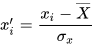

Где:
X с чертой - среднее значение выборки

Сигма x - стандартное отклонение выборки

xi - ненормализованное значение

xi' - нормализованное значение


In [6]:
class Normalize:
	def __init__(self, data: np.ndarray) -> None:
		self.data: np.ndarray = np.copy(data) # Записываем копию данных
		
		# Вычисляем среднее по каждому столбцу
		self.__mean: np.ndarray = data.mean(axis=0)
		# Вычисляем стандартное отклонение по каждому столбцу
		self.__std_dev: np.ndarray = data.std(axis=0)
		
	def normalizeData(self) -> np.ndarray:
		# Возврат нормализованных даннах по формуле
		return (self.data - self.__mean) / self.__std_dev
		
	def DeNormalizeData(
		self, normalized_data: np.ndarray, axes: list[int] = [0, 1, 2, 3]
	) -> np.ndarray:
		# Денормализация днанных по указанной оси
		return normalized_data * self.__std_dev[axes] + self.__mean[axes]

# Нормализация погодных данных
train_normalize_class = Normalize(train_data[:, 1:])
train_data[:, 1:] = train_normalize_class.normalizeData()

В данном фрагменте был создан класс, реализующий логику нормализации данных. 
В двух последних строках нормализовали обучающую выборку (кроме значений дней).
Метод DeNormalizeData позволяет интерпретировать любые данные, полученные с помощью модели, в привычной нам форме.

Построим график температуры для наглядности.

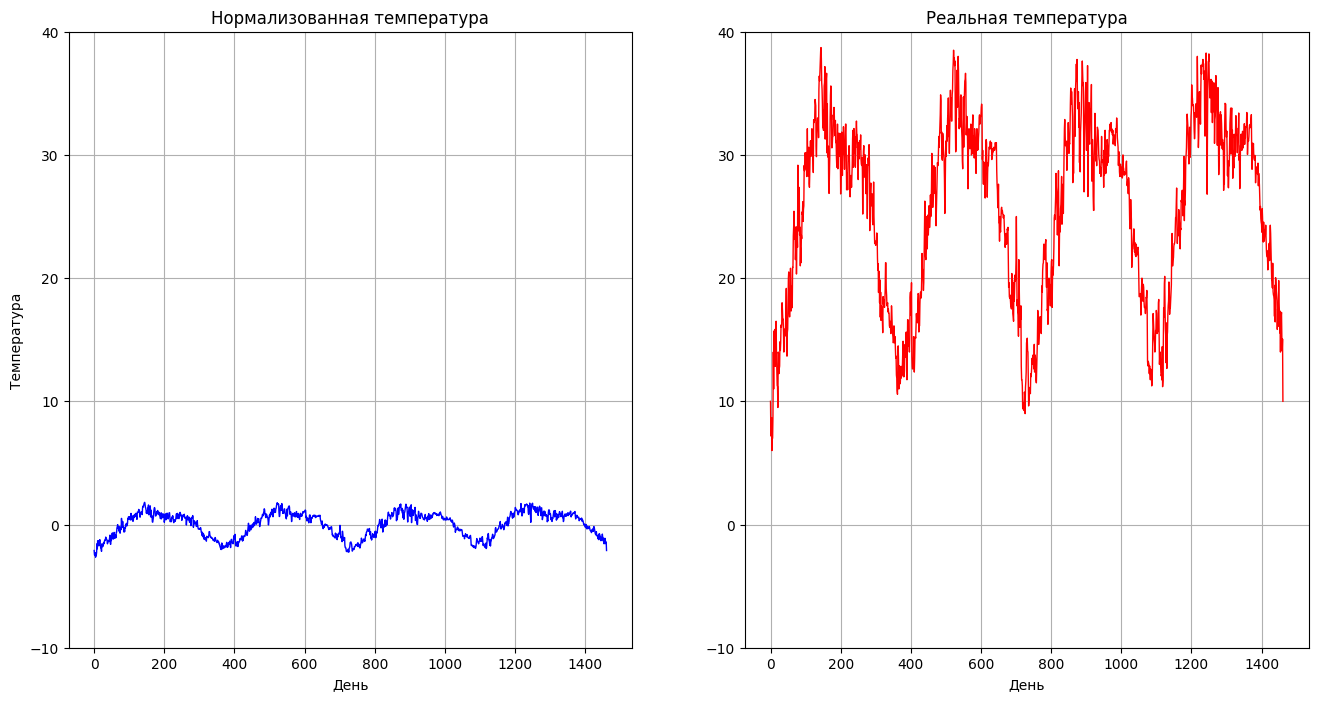

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Лимиты для осей
ax[0].set_ylim([-10, 40])
ax[1].set_ylim([-10, 40])

# Подписи осей
ax[0].set_ylabel("Температура")
ax[0].set_xlabel("День")
ax[1].set_xlabel("День")

ax[0].set_title("Нормализованная температура")
ax[1].set_title("Реальная температура")

# Сетка на осях
ax[0].grid()
ax[1].grid()

# Отображение нормализованных и ненормализованных данных на примере температуры
ax[0].plot(train_data[:, 1], c='b', linewidth=1)
ax[1].plot(
    train_normalize_class.DeNormalizeData(train_data[:, 1], axes=0),
    c='r',
    linewidth=1
)

plt.show()

Поскольку наша нейронная сеть имеет в своих нейронах значения, обозначающие вероятность, \
нам необходима нормализация данных для ограничения входного значения между (-1..1). \
Такие данные будут более удобны для анализа нейронной сетью

## Сглаживание шума

Сглаживать шум будем методом скользящей средней. Суть метода в том, что мы проходимся по всему графику "окном" определенного размера. Перемещая окно, вычисляем среднее всех значений, которые в него попали. Таким образом мы сглаживаем весь шум графика, так как он компенсирует сам себя. 

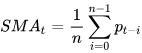 

SMAt - значение простого скользящего среднего в точке t \

n - количество значений исходной функции для расчёта скользящего среднего (размер "окна") \

p{t-i} - значение исходной функции в точке t-i

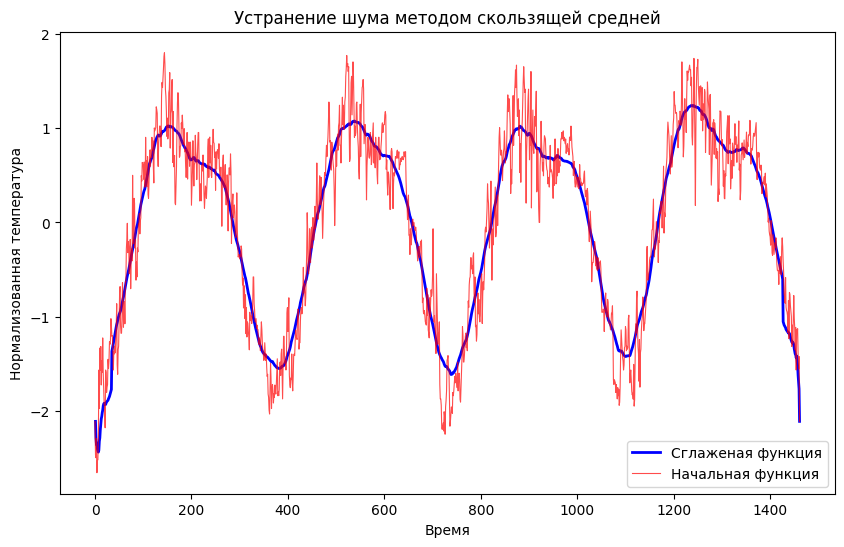

In [ ]:
def SMA(data, window=10):
	sma_values = np.zeros_like(data)
	l = window // 2
	r = (window + 1) // 2
	for i in range(data.shape[0]):
		if i < l:
			sma_values[i] = np.mean(data[:i])
		elif i < data.shape[0] - r:
			sma_values[i] = np.mean(data[i - l: i + r])
		else:
			# Здесь чтобы количество данных SMA совпадало с количеством данных по температуре 
			# SMA суммируются под конец с все меньшим и меньшим окном
			sma_values[i] = np.mean(data[i:])
	return sma_values

window_size = 70
sma_values = SMA(pd.Series(train_data[:, 1]), window_size)

plt.figure(figsize=(10, 6))
plt.plot(sma_values, label="Сглаженая функция", c='b', linewidth=2.0)
plt.plot(train_data[:, 1], label="Начальная функция", c='r', alpha=0.7, linewidth=0.8)

plt.title("Устранение шума методом скользящей средней")
plt.ylabel("Нормализованная температура")
plt.xlabel("Время")
plt.legend()

plt.show()

## Прогнозирование данных